In [11]:
from __future__ import annotations

import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
import numpy as np
import pandas as pd
import random
from ultralytics import YOLO


In [6]:

ROOT = Path.cwd().parents[0]
print("Project root:", ROOT)

DEFAULT_IMG_DIR = (
    ROOT / "data" / "subset_100" / "aug1_animals" / "images"
)
IMAGE_EXTS = {".png", ".jpg", ".jpeg", ".bmp"}


def list_images(folder: Path) -> list[Path]:
    if not folder.exists():
        raise FileNotFoundError(f"Images folder not found: {folder}")
    imgs = sorted([p for p in folder.iterdir() if p.suffix.lower() in IMAGE_EXTS])
    if not imgs:
        raise RuntimeError(f"No images found in {folder}")
    return imgs


Project root: /Users/tomeratia/Desktop/לימודים/תואר ראשון/שנה ג/GEN AI project/Autonomous_Project


In [16]:

model = YOLO(ROOT / "yolov8s.pt")
images = list_images(DEFAULT_IMG_DIR)
print(f"Found {len(images)} images in {DEFAULT_IMG_DIR}")

animal_classes = {
    "dog",
    "deer",
    "wolf",
    "cat",
    "fox",
}

results = model(images, conf=0.25)
rows: list[dict] = []

images_with_animals = 0
all_confidences: list[float] = []
detections_per_image: list[int] = []

for img_path, r in zip(images, results):
    animal_confs: list[float] = []

    for box in r.boxes:
        cls_name = model.names[int(box.cls[0])]
        if cls_name in animal_classes:
            conf = float(box.conf[0])
            animal_confs.append(conf)
            all_confidences.append(conf)

    has_animal = len(animal_confs) > 0
    if has_animal:
        images_with_animals += 1

    detections_per_image.append(len(animal_confs))

    rows.append({
        "image_name": img_path.name,
        "has_animal": has_animal,
        "num_animals": len(animal_confs),
        "avg_animal_conf": float(np.mean(animal_confs)) if animal_confs else np.nan,
        "detected_animals": [
            model.names[int(box.cls[0])]
            for box in r.boxes
            if model.names[int(box.cls[0])] in animal_classes
        ],
    })

detection_rate = images_with_animals / len(images)
avg_confidence = float(np.mean(all_confidences)) if all_confidences else 0.0
avg_detections = float(np.mean(detections_per_image)) if detections_per_image else 0.0

df = pd.DataFrame(rows)



Found 89 images in /Users/tomeratia/Desktop/לימודים/תואר ראשון/שנה ג/GEN AI project/Autonomous_Project/data/subset_100/aug1_animals/images

0: 640x640 1 car, 1 horse, 170.7ms
1: 640x640 1 car, 6 traffic lights, 1 stop sign, 1 dog, 170.7ms
2: 640x640 4 persons, 6 cars, 170.7ms
3: 640x640 3 cars, 170.7ms
4: 640x640 5 cars, 1 motorcycle, 1 truck, 170.7ms
5: 640x640 9 cars, 1 traffic light, 1 stop sign, 170.7ms
6: 640x640 9 cars, 1 traffic light, 1 stop sign, 2 dogs, 170.7ms
7: 640x640 1 person, 2 cars, 1 traffic light, 170.7ms
8: 640x640 6 cars, 1 bench, 1 cat, 170.7ms
9: 640x640 3 cars, 1 traffic light, 1 bird, 1 dog, 170.7ms
10: 640x640 3 persons, 2 cars, 1 traffic light, 170.7ms
11: 640x640 2 persons, 1 car, 170.7ms
12: 640x640 3 persons, 2 bicycles, 1 bench, 1 dog, 170.7ms
13: 640x640 1 person, 3 cars, 1 dog, 170.7ms
14: 640x640 2 persons, 3 bicycles, 2 cars, 1 traffic light, 1 dog, 170.7ms
15: 640x640 3 persons, 3 bicycles, 3 cars, 1 traffic light, 1 dog, 170.7ms
16: 640x640 6 cars, 

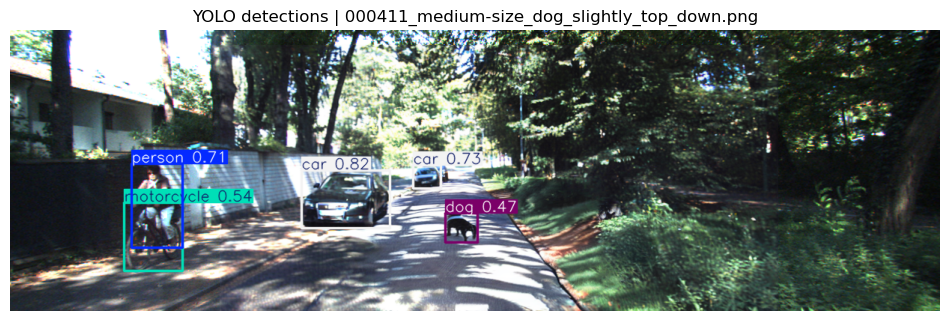

In [14]:


idxs = df.index[df["has_animal"] == True].tolist()
idx = random.choice(idxs) if idxs else 0

img_path = images[idx]
r = results[idx]

annotated = r.plot()  # numpy array (BGR)

plt.figure(figsize=(12, 6))
plt.title(f"YOLO detections | {img_path.name}")
plt.imshow(annotated[..., ::-1])  # BGR -> RGB
plt.axis("off")
plt.show()

In [15]:
print("\n=== Baseline Metrics ===")
print(f"Detection rate: {detection_rate:.3f}")
print(f"Average confidence: {avg_confidence:.3f}")
print(f"Avg detections per image: {avg_detections:.2f}")

display(df)

print("\n=== Data Summary ===")
print("Images with animals:", df["has_animal"].sum())
print("Images without animals:", (~df["has_animal"]).sum())




=== Baseline Metrics ===
Detection rate: 0.472
Average confidence: 0.705
Avg detections per image: 0.48


,image_name,has_animal,num_animals,avg_animal_conf,detected_animals
0,000004_deer_three_quarter_view.png,False,0,NaN,[]
1,000015_fox_from_behind.png,True,1,0.773883,[dog]
2,000080_medium-size_dog_side_view.png,False,0,NaN,[]
3,000105_wolf_front_view.png,False,0,NaN,[]
4,000128_wolf_three_quarter_view.png,False,0,NaN,[]
...,...,...,...,...,...
84,001732_fox_side_view.png,False,0,NaN,[]
85,001735_fox_low_angle.png,True,1,0.681474,[dog]
86,001780_cat_slightly_top_down.png,False,0,NaN,[]
87,001784_medium-size_dog_from_behind.png,False,0,NaN,[]



=== Data Summary ===
Images with animals: 42
Images without animals: 47
